In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

In [6]:
adult_df = pd.read_csv('data/adult23.csv')
adult_df.columns

Index(['URBRRL', 'RATCAT_A', 'INCTCFLG_A', 'IMPINCFLG_A', 'LANGSPECR_A',
       'LANGSOC_A', 'LANGDOC_A', 'LANGMED_A', 'LANGHM_A', 'PPSU',
       ...
       'PROXYREL_A', 'PROXY_A', 'AVAIL_A', 'HHSTAT_A', 'INTV_MON', 'RECTYPE',
       'IMPNUM_A', 'WTFA_A', 'HHX', 'POVRATTC_A'],
      dtype='object', length=647)

In [7]:
# Sampling for individuals with response 1 - Yes to 'Ever been told you have coronary heart disease?' 
heart_df = adult_df[adult_df['CHDEV_A'] == 1]

In [10]:
# Filtering for columns corresponding to questions related to cardiovascular health
# HYPEV_A, HYPDIF_A, HYP12M_A, HYPMED_A, CHLEV_A, CHL12M_A, CHLMED_A, CHDEV_A, ANGEV_A, MIEV_A, STREV_A, PREDIB_A, DIBEV_A, BMICAT_A, 
# ANXEV_A, SEX_A, AGEP_A

heart_df = heart_df[['SEX_A', 'AGEP_A' ,'HYPEV_A','CHLEV_A', 'CHDEV_A', 
               'ANGEV_A', 'MIEV_A', 'STREV_A', 'PREDIB_A', 'DIBEV_A', 'BMICAT_A', 'ANXEV_A']]
heart_df

,SEX_A,AGEP_A,HYPEV_A,CHLEV_A,CHDEV_A,ANGEV_A,MIEV_A,STREV_A,PREDIB_A,DIBEV_A,BMICAT_A,ANXEV_A
1,1,73,1,2,1,2,1,2,1,1,3,2
37,2,56,1,1,1,2,2,2,2,2,4,2
47,1,71,1,1,1,2,2,2,2,2,4,1
69,1,65,1,1,1,2,2,2,1,2,3,1
78,2,70,1,1,1,2,1,2,1,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
29441,1,68,1,1,1,2,2,2,1,2,4,2
29442,1,81,2,1,1,2,2,2,2,2,3,2
29481,2,76,1,1,1,2,1,1,1,1,4,2
29487,1,72,1,1,1,1,2,2,1,1,1,1


In [12]:
# Imputing NaN values by replacing them with most common values (mean values do not work because there's only binary values)
# Also reformatted float values into int
# If column has lots of nulls, exclude it. Drop rows with nulls (if too many replace with most common) 
# Also dropping rows with values 7 - Refused, 8 - Ascertained, 9 - Don't Know as they might interfere with clustering

cols = heart_df.columns
heart_df = heart_df[~heart_df.isin([7, 8, 9])]
for col in cols:
    if heart_df[col].isna().any():
        heart_df[col] = heart_df[col].fillna(heart_df[col].mode()[0])
    if heart_df[col].dtype == 'float64':
        heart_df[col].astype('int64')
heart_df

,SEX_A,AGEP_A,HYPEV_A,CHLEV_A,CHDEV_A,ANGEV_A,MIEV_A,STREV_A,PREDIB_A,DIBEV_A,BMICAT_A,ANXEV_A
1,1,73,1.0,2.0,1,2.0,1.0,2.0,1.0,1.0,3.0,2.0
37,2,56,1.0,1.0,1,2.0,2.0,2.0,2.0,2.0,4.0,2.0
47,1,71,1.0,1.0,1,2.0,2.0,2.0,2.0,2.0,4.0,1.0
69,1,65,1.0,1.0,1,2.0,2.0,2.0,1.0,2.0,3.0,1.0
78,2,70,1.0,1.0,1,2.0,1.0,2.0,1.0,2.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29441,1,68,1.0,1.0,1,2.0,2.0,2.0,1.0,2.0,4.0,2.0
29442,1,81,2.0,1.0,1,2.0,2.0,2.0,2.0,2.0,3.0,2.0
29481,2,76,1.0,1.0,1,2.0,1.0,1.0,1.0,1.0,4.0,2.0
29487,1,72,1.0,1.0,1,1.0,2.0,2.0,1.0,1.0,1.0,1.0


In [14]:
# Combining these 1833 rows of Yes responses for heart disease with a random sample of 1833 rows of No responses
# Cleaning the No responses the same way we did with the Yes responses

no_heart_df = adult_df[adult_df['CHDEV_A'] == 2]
no_heart_df = no_heart_df[['SEX_A', 'AGEP_A' ,'HYPEV_A','CHLEV_A', 'CHDEV_A', 
               'ANGEV_A', 'MIEV_A', 'STREV_A', 'PREDIB_A', 'DIBEV_A', 'BMICAT_A', 'ANXEV_A']]
no_heart_df = no_heart_df.sample(n=len(heart_df), random_state=42)
no_heart_df = no_heart_df[~no_heart_df.isin([7, 8, 9])]

for col in no_heart_df.columns:
    null_count = no_heart_df[col].isnull().sum()
    if null_count < len(no_heart_df) / 4:
        no_heart_df = no_heart_df.dropna(subset=[col])
    else:
        mode = no_heart_df[col].mode()[0] if not no_heart_df[col].mode().empty else None
        no_heart_df[col].fillna(mode, inplace=True)

no_heart_df

,SEX_A,AGEP_A,HYPEV_A,CHLEV_A,CHDEV_A,ANGEV_A,MIEV_A,STREV_A,PREDIB_A,DIBEV_A,BMICAT_A,ANXEV_A
23335,2,59,1.0,2.0,2,2,2,2,2.0,2.0,3.0,2
23564,1,62,1.0,2.0,2,2,2,2,2.0,2.0,2.0,2
28904,2,40,1.0,2.0,2,2,2,2,2.0,2.0,2.0,2
18921,1,68,2.0,2.0,2,2,2,2,2.0,2.0,3.0,2
15022,1,44,2.0,2.0,2,2,2,2,2.0,2.0,4.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
8097,2,29,2.0,2.0,2,2,2,2,2.0,2.0,3.0,2
28261,2,70,2.0,2.0,2,2,2,2,2.0,2.0,4.0,2
1795,2,46,1.0,1.0,2,2,2,2,1.0,1.0,4.0,1
586,2,23,2.0,2.0,2,2,2,2,2.0,2.0,1.0,2


In [16]:
# Doing final feature engineering step by changing all values to binary
merged_heart_df = pd.concat([heart_df, no_heart_df])
merged_heart_df['BMICAT_A'] = merged_heart_df['BMICAT_A'].map({1: 0, 2: 0, 3: 0, 4: 1})

# Changing column values to binary: 0 - No, 1 - Yes (Original data had 1 - Yes, 2 - No)
# BMICAT_A: 1 - Underweight, 2 - Healthy weight, 3 - overweight and 4 - obese changed to 1, 2, 3 - 0 (Not obese) and 4 - 1 (is obese)
# SEX_A: 1 - Male, 2 - Female changed to 1 - Male, 0 - Female
cols_to_change = ['SEX_A','HYPEV_A','CHLEV_A', 'CHDEV_A', 'ANGEV_A', 'MIEV_A', 'STREV_A', 'PREDIB_A', 'DIBEV_A', 'ANXEV_A']

for col in cols_to_change:
    merged_heart_df[col] = merged_heart_df[col].astype(int)
    merged_heart_df[col] = merged_heart_df[col].map({2: 0, 1: 1})

merged_heart_df.to_csv('NIH_clean_data', index=False)
merged_heart_df

,SEX_A,AGEP_A,HYPEV_A,CHLEV_A,CHDEV_A,ANGEV_A,MIEV_A,STREV_A,PREDIB_A,DIBEV_A,BMICAT_A,ANXEV_A
1,1,73,1,0,1,0,1,0,1,1,0,0
37,0,56,1,1,1,0,0,0,0,0,1,0
47,1,71,1,1,1,0,0,0,0,0,1,1
69,1,65,1,1,1,0,0,0,1,0,0,1
78,0,70,1,1,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8097,0,29,0,0,0,0,0,0,0,0,0,0
28261,0,70,0,0,0,0,0,0,0,0,1,0
1795,0,46,1,1,0,0,0,0,1,1,1,1
586,0,23,0,0,0,0,0,0,0,0,0,0


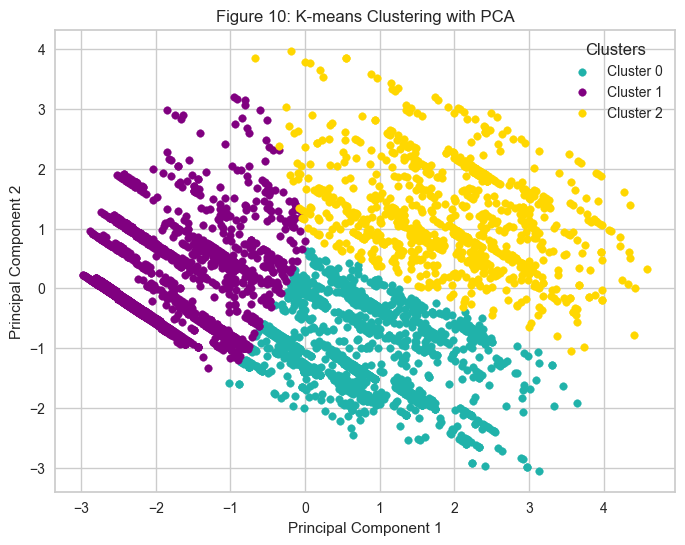

In [150]:
# Performing k-means clustering on the merged dataframe, reducing dimensions with PCA on two dimensions and plotting clusters
# Also generating elbow visualization for best k clusters

from yellowbrick.cluster import KElbowVisualizer

X = merged_heart_df[['SEX_A', 'AGEP_A' ,'HYPEV_A','CHLEV_A', 'CHDEV_A', 
               'ANGEV_A', 'MIEV_A', 'STREV_A', 'PREDIB_A', 'DIBEV_A', 'BMICAT_A', 'ANXEV_A']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_clusters = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8, 6))
colors = ['lightseagreen', 'purple', 'gold']
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2']

for c in range(3):
    plt.scatter(X_pca[kmeans_clusters == c, 0], X_pca[kmeans_clusters == c, 1], color=colors[c], label=labels[c],
               s=30)
plt.title('Figure 10: K-means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Clusters')

plt.show()


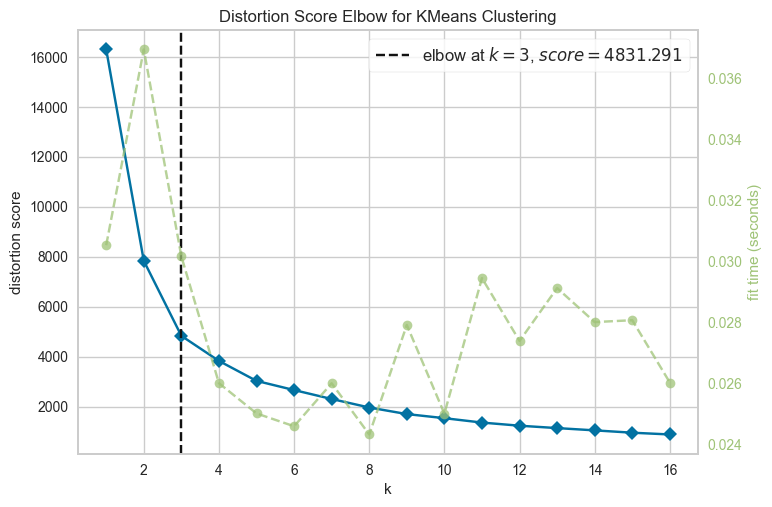

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [158]:
k_elbow = KElbowVisualizer(kmeans, k=(1, 17))
k_elbow.fit(X_pca)
k_elbow.show()

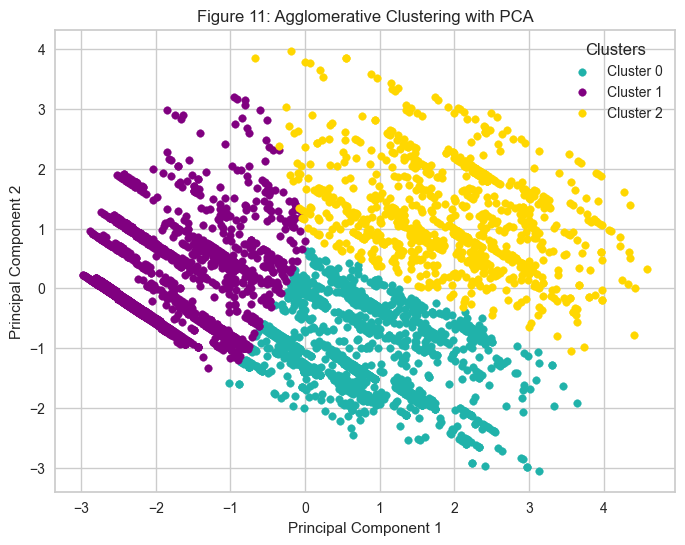

In [156]:
# trying agglomerative clustering to see if it improves on k-means

from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3, linkage='complete', metric='euclidean')
assignment = agg.fit_predict(X_pca)

plt.figure(figsize=(8, 6))
colors = ['lightseagreen', 'purple', 'gold']
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2']

for c in range(3):
    plt.scatter(X_pca[kmeans_clusters == c, 0], X_pca[kmeans_clusters == c, 1], color=colors[c], label=labels[c],
               s=30)
plt.title('Figure 11: Agglomerative Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Clusters')

plt.show()

In [144]:
# agglomerative clustering silhouette score

agg_silhouette = silhouette_score(X_pca, assignment, metric='euclidean')
print(agg_silhouette)

0.36714088662665506


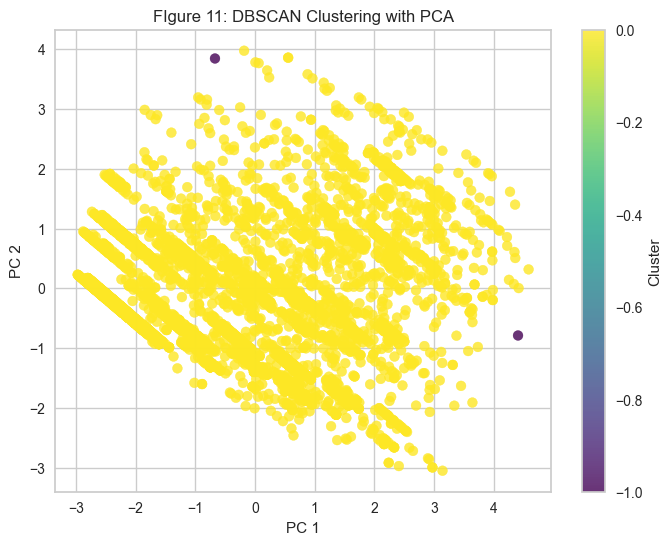

In [154]:
# Trying the DBSCAN algorithm to see if silhouette score improves
dbscan = DBSCAN(eps=0.5, min_samples=5)
merged_heart_df['DBSCAN Cluster'] = dbscan.fit_predict(X_pca)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=merged_heart_df['DBSCAN Cluster'], cmap='viridis', s=50, alpha=0.8)
plt.title('FIgure 11: DBSCAN Clustering with PCA')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Cluster')
plt.show()

In [148]:
# Silhouette score for DBSCAN 

db_silhouette = silhouette_score(X_pca, merged_heart_df['DBSCAN Cluster'])
db_silhouette

0.39047483995092186